In [22]:
# !pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
import torch.nn as nn

1.5.1+cu101


### 1. Data Generation  (Preparation)

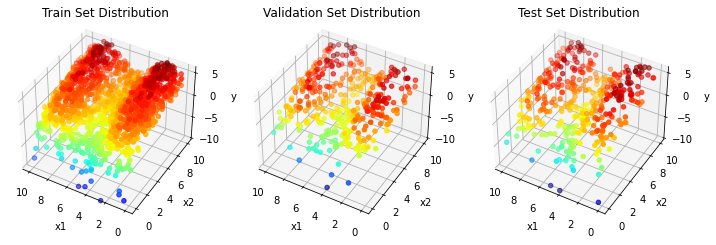

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e
# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)  

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됩니다. 이 때`in_features`는 x의 차원이고, `out_features`는 y의 차원입니다.  


**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

## LinearModel Class

In [3]:
class LinearModel(nn.Module):
    # 초기화 및 입력값을 어떤 것 받을 것인지 지정할 때 문법
    # 형식은 항상 동일함
    def __init__(self):
        super(LinearModel, self).__init__()
        # hidden layer 없을 때
        self.linear = nn.Linear(in_feature=2, out_feature=1, bias=True)
        
    # 실질적으로 구현    
    def forward(self, x):
        return self.linear(x) 

## MLPModel Class

In [23]:
class MLPModel(nn.Module):
    # 클래스 선언할 때의 문법
    def __init__(self, in_dim, out_dim, hid_dim):
        super(MLPModel, self).__init__()
        # hidden layer이 있으니 in_dim에서 hid_dim으로 한번 보내고 다시hid_dim에서 out_dim으로 보냄
        self.linear1 = nn.Linear(in_dim, hid_dim)
        self.linear2 = nn.Linear(hid_dim, out_dim)
        # Activation function
        self.act = nn.ReLU()
        
    # x를 input으로 받았을 때 구현
    def forward(self, x):
        # x를 linear1 거쳐간 것으로 최신화
        x = self.linear1(x)
        # 최신화된 x에 activation function에 적용.
        x = self.act(x)
        # activation function 적용된 x에 linear2 거침
        x = self.linear2(x)
        # x 리턴
        return x
    
# in_dim = 2, hid_dim = 200, out_dim = 1인 MLPModel 객체 m 생성
m = MLPModel(2,1,200)

## MY_MLPModel with nn.ModuleList

In [29]:
class My_MLPModel(nn.Module):
    def __init__(self, hidden_nodes):
        super().__init__()
        nodes = (784,) + hidden_nodes + (10,)
        depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(depth-1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        self.depth = depth
        
    def forward(self, x):
        for linear in self.linears:
            x = linear(x)
            x = self.relu(x)
        return x

In [4]:
reg_loss = nn.MSELoss()

# uncomment for testing Loss Function
# input이 뭐고 어떻게 넣어줘야할 지 모르겠을때는 테스트를 해보자.
# torch에서 넣어줄때는 torch.tensor로 변환하여 넣어주자
"""
test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))
"""

'\ntest_pred_y = torch.Tensor([0,0,0,0])\ntest_true_y = torch.Tensor([0,1,0,1])\n\nprint(reg_loss(test_pred_y, test_true_y))\nprint(reg_loss(test_true_y, test_true_y))\n'

  0%|          | 0/4000 [00:00<?, ?it/s]

801 parameters


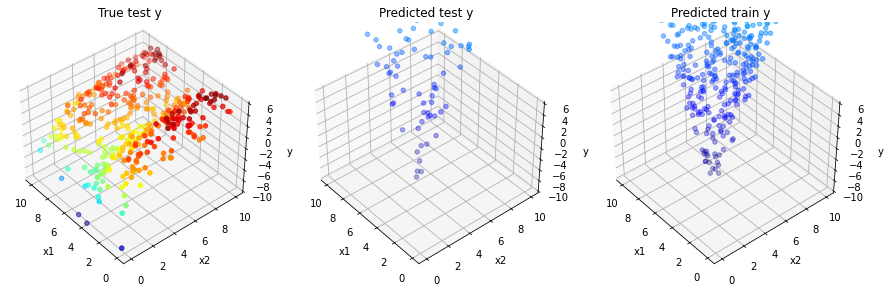

  0%|          | 17/4000 [00:00<20:11,  3.29it/s]

0 tensor(1555.3589, grad_fn=<MseLossBackward>)


  4%|▍         | 151/4000 [00:01<03:34, 17.94it/s]

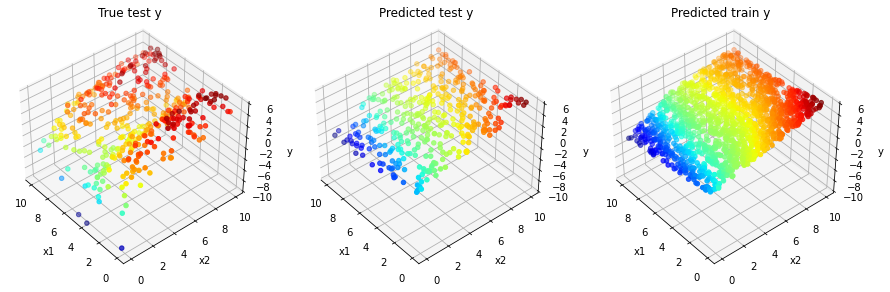

  5%|▌         | 217/4000 [00:01<02:02, 30.87it/s]

200 tensor(2.4970, grad_fn=<MseLossBackward>)


  9%|▉         | 377/4000 [00:02<00:36, 98.94it/s]

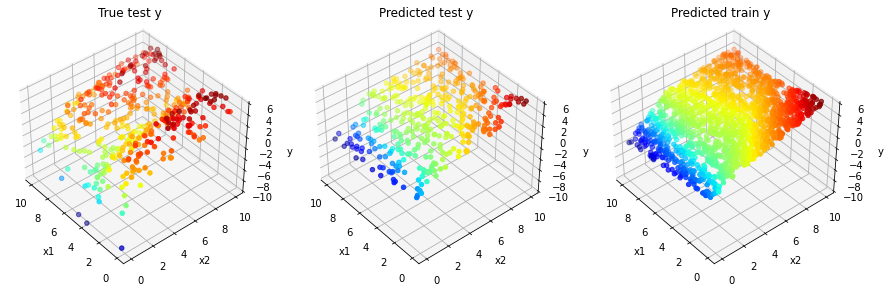

 10%|█         | 417/4000 [00:03<00:49, 72.89it/s]

400 tensor(2.2083, grad_fn=<MseLossBackward>)


 15%|█▌        | 600/4000 [00:03<00:18, 187.67it/s]

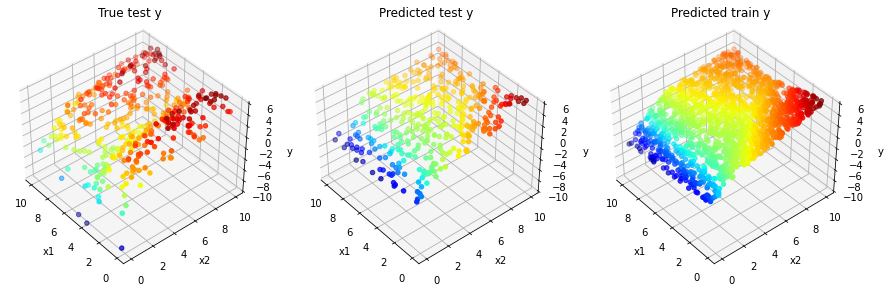

600 tensor(2.0442, grad_fn=<MseLossBackward>)


 20%|█▉        | 784/4000 [00:06<00:31, 102.13it/s]

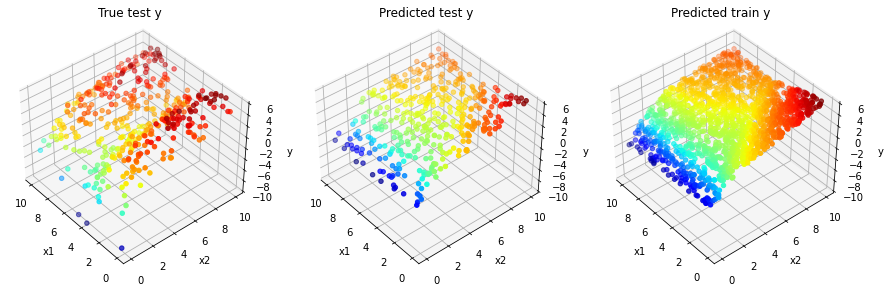

 21%|██        | 842/4000 [00:06<00:36, 87.48it/s] 

800 tensor(1.9365, grad_fn=<MseLossBackward>)


 25%|██▍       | 995/4000 [00:08<00:29, 103.05it/s]

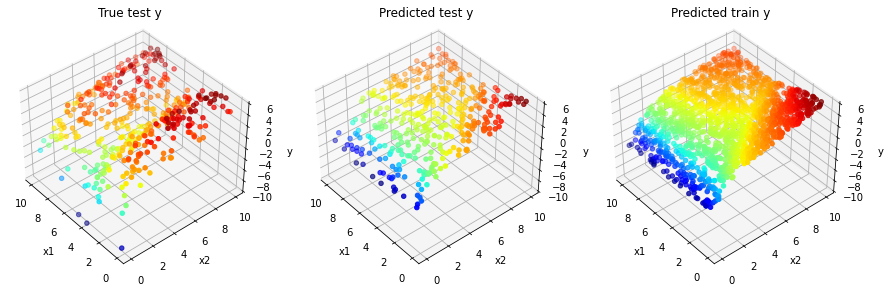

 26%|██▌       | 1022/4000 [00:08<00:40, 74.24it/s]

1000 tensor(1.8508, grad_fn=<MseLossBackward>)


 30%|██▉       | 1198/4000 [00:09<00:15, 181.53it/s]

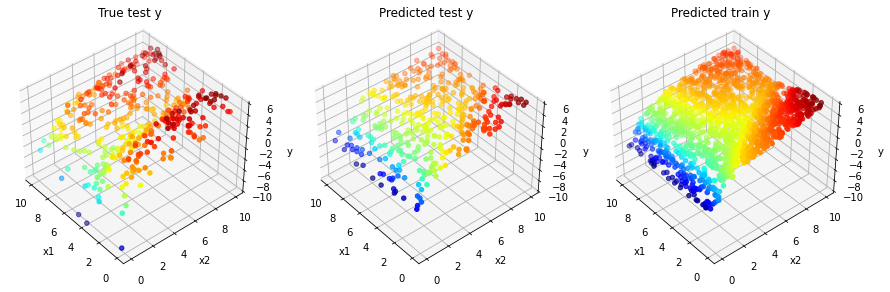

1200 tensor(1.7753, grad_fn=<MseLossBackward>)


 35%|███▍      | 1398/4000 [00:11<00:31, 83.76it/s] 

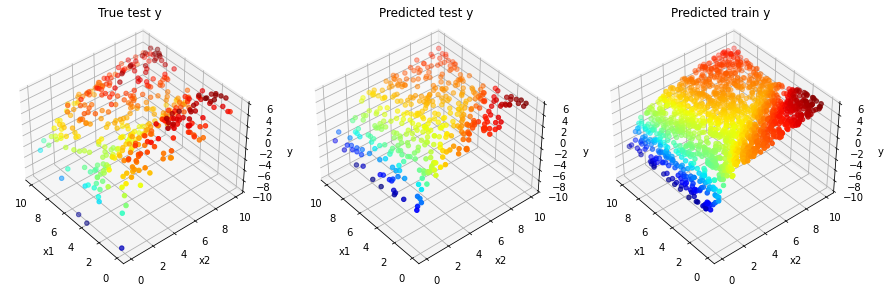

1400 tensor(1.7056, grad_fn=<MseLossBackward>)


 39%|███▉      | 1552/4000 [00:13<00:28, 85.23it/s]

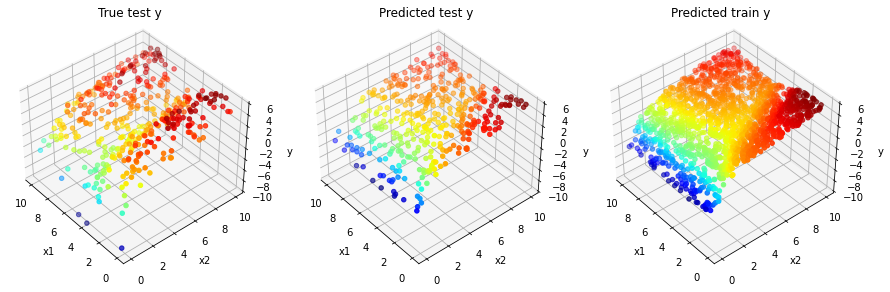

 41%|████      | 1623/4000 [00:14<00:25, 93.92it/s]

1600 tensor(1.6386, grad_fn=<MseLossBackward>)


 45%|████▍     | 1790/4000 [00:15<00:14, 152.45it/s]

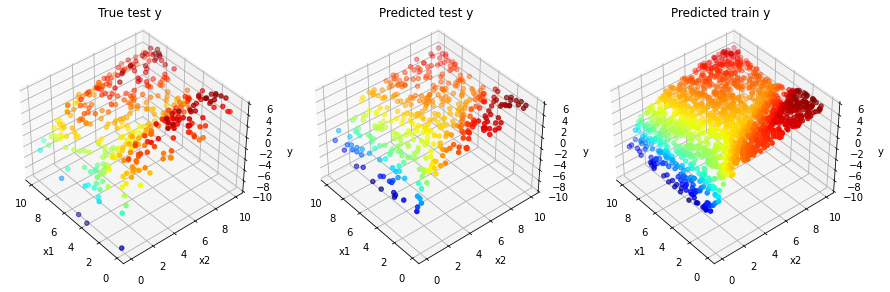

 45%|████▌     | 1809/4000 [00:16<00:33, 65.45it/s] 

1800 tensor(1.5740, grad_fn=<MseLossBackward>)


 50%|█████     | 2000/4000 [00:16<00:10, 189.59it/s]

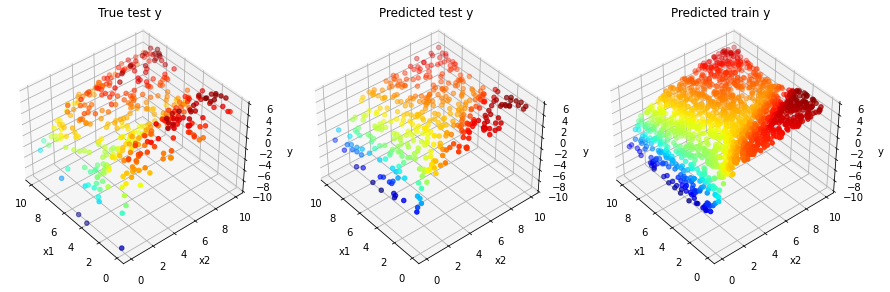

2000 tensor(1.5126, grad_fn=<MseLossBackward>)


 55%|█████▍    | 2198/4000 [00:17<00:08, 222.78it/s]

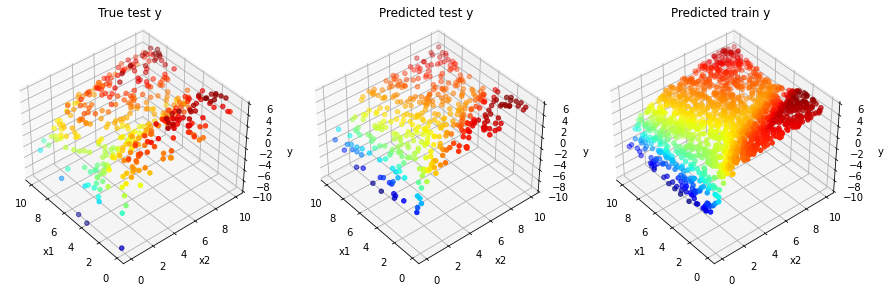

2200 tensor(1.4511, grad_fn=<MseLossBackward>)


 60%|█████▉    | 2393/4000 [00:18<00:10, 158.75it/s]

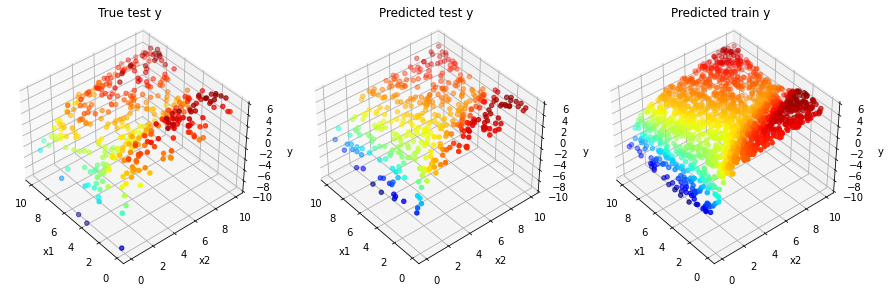

2400 tensor(1.4071, grad_fn=<MseLossBackward>)


 64%|██████▍   | 2568/4000 [00:20<00:08, 163.20it/s]

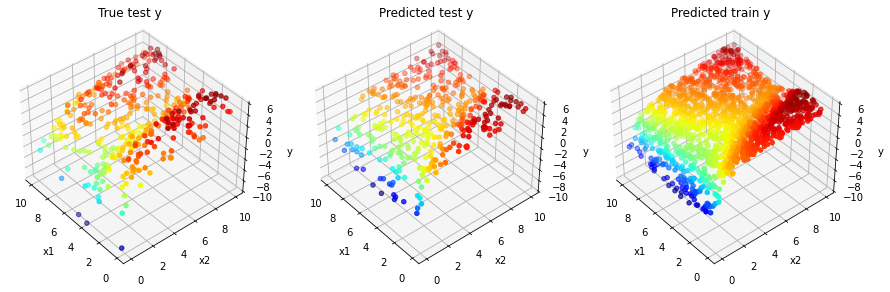

 65%|██████▌   | 2607/4000 [00:21<00:13, 105.77it/s]

2600 tensor(1.3679, grad_fn=<MseLossBackward>)


 70%|██████▉   | 2791/4000 [00:22<00:08, 135.87it/s]

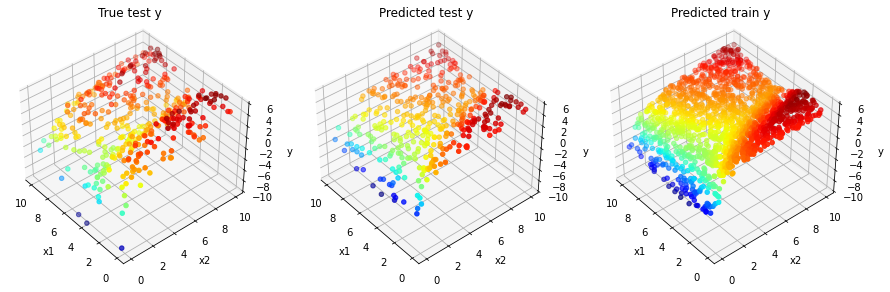

 70%|███████   | 2813/4000 [00:23<00:18, 65.32it/s] 

2800 tensor(1.3356, grad_fn=<MseLossBackward>)


 74%|███████▍  | 2972/4000 [00:23<00:06, 148.70it/s]

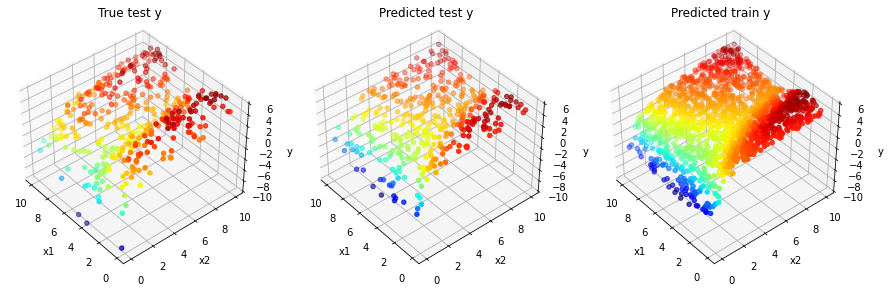

 76%|███████▌  | 3032/4000 [00:24<00:10, 95.78it/s] 

3000 tensor(1.3077, grad_fn=<MseLossBackward>)


 80%|███████▉  | 3183/4000 [00:25<00:06, 131.39it/s]

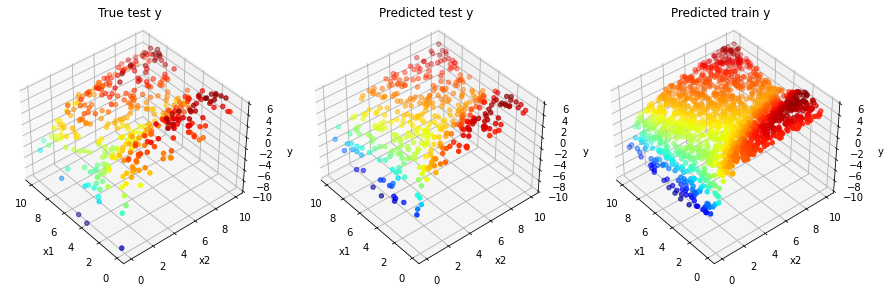

 80%|████████  | 3202/4000 [00:26<00:10, 75.41it/s] 

3200 tensor(1.2815, grad_fn=<MseLossBackward>)


 85%|████████▍ | 3391/4000 [00:26<00:03, 169.06it/s]

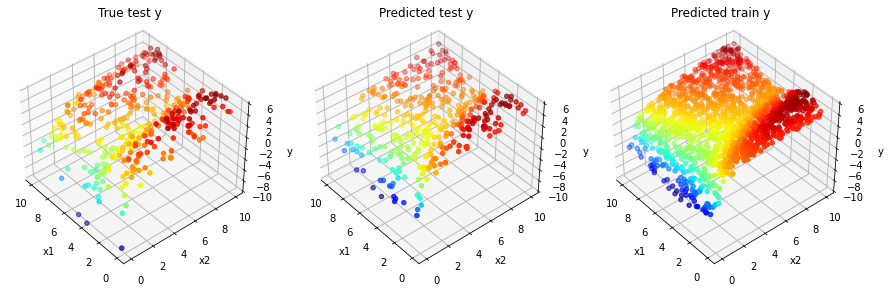

 86%|████████▌ | 3430/4000 [00:27<00:04, 116.51it/s]

3400 tensor(1.2581, grad_fn=<MseLossBackward>)


 89%|████████▉ | 3562/4000 [00:28<00:02, 174.45it/s]

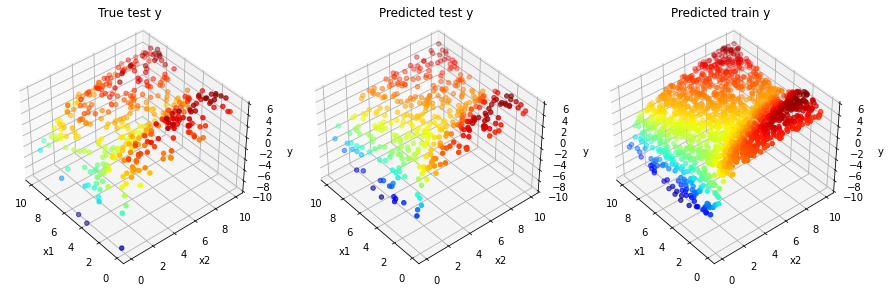

 90%|█████████ | 3601/4000 [00:28<00:03, 127.23it/s]

3600 tensor(1.2336, grad_fn=<MseLossBackward>)


 94%|█████████▍| 3761/4000 [00:30<00:03, 76.09it/s] 

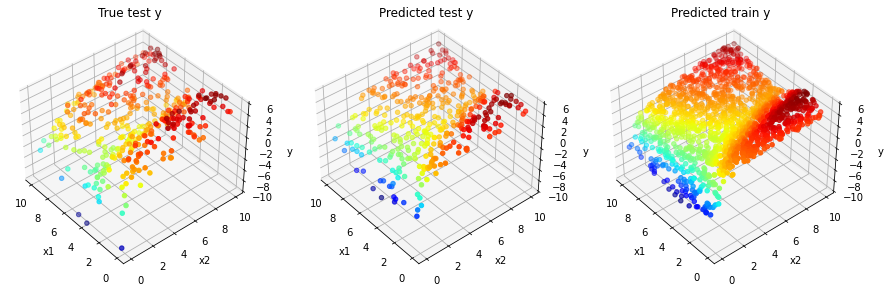

 95%|█████████▌| 3819/4000 [00:31<00:02, 89.37it/s]

3800 tensor(1.2006, grad_fn=<MseLossBackward>)


100%|██████████| 4000/4000 [00:31<00:00, 125.85it/s]


In [8]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm


# ====== Construct Model ====== #
model = MLPModel(2, 1, 200) # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in tqdm(range(epoch)):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = reg_loss(pred_y.squeeze(), true_y) # squeeze를 이용하여 불필요한 ,1 삭제
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

# Test

In [31]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# ====== Construct Model ====== #
model = MY_MLPModel(10) # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in tqdm(range(epoch)):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = reg_loss(pred_y.squeeze(), true_y) # squeeze를 이용하여 불필요한 ,1 삭제
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

ModuleNotFoundError: No module named 'MY_MLPModel'

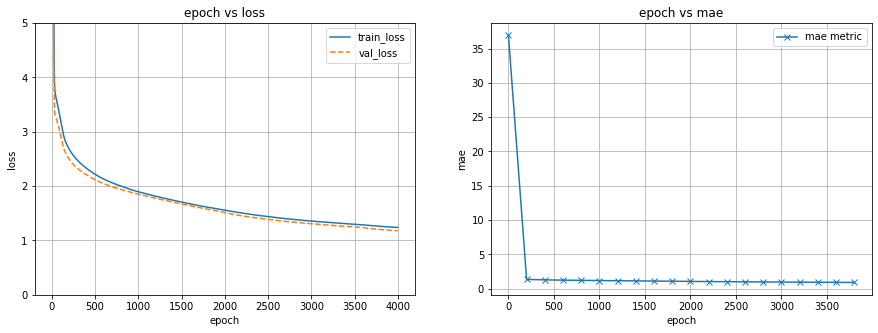

In [9]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()

# Assignment1. MNIST Digit Recogntion

### 1. Data Preparation

In [16]:
!pwd

/home/euiseokjeong/Desktop/WIL-What-I-learned-


In [21]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html